In [23]:
# Import Dependencies
import pandas as pd
import numpy as np
import joblib

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# Plots as needed
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Data split
from sklearn.model_selection import StratifiedShuffleSplit

# Model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ARDRegression

# Model Validation and Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# MSE minimization
from sklearn.metrics import mean_squared_error
from scipy import optimize

# DB interface
from sqlalchemy import create_engine
from config import db_password

## Interface with Database and create DataFrames

In [5]:
# Construct db string
user = 'postgres'
host = 'housing-prices.ch2ctomvepex.us-east-1.rds.amazonaws.com'
name = 'housing-prices'

db_string = f'postgresql://{user}:{db_password}@{host}/{name}'

In [6]:
# Create Connection Engine

engine = create_engine(db_string)

In [7]:
# Example - load data from RDS into pandas DataFrame

sf_db = pd.read_sql_table('sanfran', engine)
sf_db.head()

,price,bedroom,sqft,neighborhood,bathroom,amenity_count,cityid
0,3985,2,920.0,cole valley / ashbury hts,1.0,5,2
1,3961,1,745.0,SOMA / south beach,1.0,9,2
2,7435,3,1146.0,SOMA / south beach,2.0,9,2
3,2785,2,1000.0,alamo square / nopa,1.5,7,2
4,7250,3,1146.0,SOMA / south beach,2.0,9,2


In [17]:
# Example Data from CSV used here

# Import Data
sf_df = pd.read_csv("../../First Segment Rubric - Sample Data/sf_clean.csv")
sf_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


## Temp Data from CSVs

In [4]:
# Create city list and general path

# TODO: Edit to match RDS table names
city_list = ['austin','boston','sf','chandler','chicago','houston','la','pittsburgh','spokane']

# Group by city population
low_list = ['chandler', 'pittsburgh', 'spokane']
mid_list = ['austin', 'boston', 'sf']
high_list = ['chicago', 'la', 'houston']

# TODO: Edit to match RDS path
general_path = '../../First Segment Rubric - Clean/csv/'

In [29]:
# Create dataframes for each pop grouping and overall

def build_dfs(cities, gen_path, lowpop_list=[], midpop_list=[], highpop_list=[]):
    
    # Dummy cityID for cities temp. missing it
    dummy_id = 10

    low_pop = pd.DataFrame()
    mid_pop = pd.DataFrame()
    high_pop = pd.DataFrame()
    all_pop = pd.DataFrame()

    # Iterate through cities to get data
    for city in cities:
        
        city_fp = f'{gen_path}{city}_clean_data.csv'
        
        
        # Determine low, mid, or high pop
        
        if city in lowpop_list:
            
            # Create temp city df
            city = pd.read_csv(city_fp)
        
            # Check for cityID
            if city.columns[-1] != 'cityID':
                city['cityID'] = dummy_id
                dummy_id = dummy_id + 1
                
            # Check for num amen
            if 'number of amenities' in city.columns:
                city['amenity_count'] = city['number of amenities']
                city = city.drop(columns='number of amenities', axis=1)
                
            # Add class col
            city['pop_class'] = 1
            
            # Add to low df
            low_pop = pd.concat([low_pop,city])
                
        elif city in midpop_list:
            
           # Create temp city df
            city = pd.read_csv(city_fp)
        
            # Check for cityID
            if city.columns[-1] != 'cityID':
                city['cityID'] = dummy_id
                dummy_id = dummy_id + 1
            
            # Check for num amen
            if 'number of amenities' in city.columns:
                city['amenity_count'] = city['number of amenities']
                city = city.drop(columns='number of amenities', axis=1)
            
            # Add class col
            city['pop_class'] = 2
            
            # Add to mid df
            mid_pop = pd.concat([mid_pop,city])
                
        elif city in highpop_list:
            
            # Create temp city df
            city = pd.read_csv(city_fp)
        
            # Check for cityID
            if city.columns[-1] != 'cityID':
                city['cityID'] = dummy_id
                dummy_id = dummy_id + 1
                
            # Check for num amen    
            if 'number of amenities' in city.columns:
                city['amenity_count'] = city['number of amenities']
                city = city.drop(columns='number of amenities', axis=1)
            
            # Add class col
            city['pop_class'] = 3
            
            # Add to high df
            high_pop = pd.concat([high_pop,city])
        
        
        # add to all_pop
        
        all_pop = pd.concat([all_pop,city])
        
        
    return low_pop, mid_pop, high_pop, all_pop

In [30]:
# Call fn to create dfs
low_pop, mid_pop, high_pop, all_pop = build_dfs(city_list, general_path, low_list,
                                               mid_list, high_list)

In [31]:
# Drop duplicate listings if any exist

low_pop.drop_duplicates(subset=['price','bedroom','sqft','neighborhood','bathroom','amenity_count'], inplace=True)
mid_pop.drop_duplicates(subset=['price','bedroom','sqft','neighborhood','bathroom','amenity_count'], inplace=True)
high_pop.drop_duplicates(subset=['price','bedroom','sqft','neighborhood','bathroom','amenity_count'], inplace=True)
all_pop.drop_duplicates(subset=['price','bedroom','sqft','neighborhood','bathroom','amenity_count'], inplace=True)

## Examine data

In [32]:
# Before examination, split so that the test set remains unobserved

# Split using SSS to incorporate data from each of the 3 groups in test and train sets.
split = StratifiedShuffleSplit(n_splits=10,test_size=0.2, random_state=42)

for train_index, test_index in split.split(all_pop, all_pop['pop_class']):
    strat_train_set = all_pop.iloc[train_index]
    strat_test_set = all_pop.iloc[test_index]

In [33]:
# Create a new df that is a copy of the training set to preserve it.
all_train = strat_train_set.copy()

# Drop columns not used in analysis
all_train.drop(columns=['neighborhood','cityID','pop_class'],axis=1,inplace=True)

# Repeat for test set
all_test = strat_test_set.copy()
all_test.drop(columns=['neighborhood','cityID','pop_class'],axis=1,inplace=True)

# Show first 5 rows of training set
all_train.head()

,price,bedroom,sqft,bathroom,amenity_count
69,2500,2,860.0,1.0,3
55,4000,3,1700.0,2.0,5
58,1518,1,794.0,1.0,6
79,2200,3,1400.0,2.0,4
38,2000,3,1491.0,2.5,3


In [10]:
# Create a df of corr between features
corr_matrix = all_train.corr()

# Display each feature's corr with target
corr_matrix.price.sort_values(ascending=False)

price            1.000000
sqft             0.469988
bathroom         0.416403
bedroom          0.346331
amenity_count   -0.039219
Name: price, dtype: float64

<AxesSubplot:>

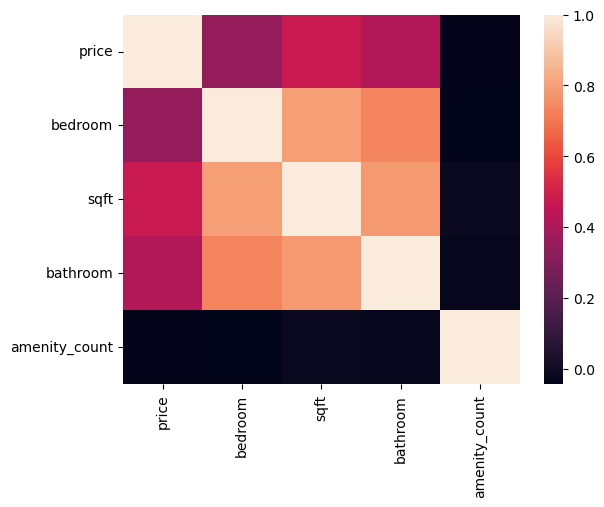

In [11]:
# Plot corr
sns.heatmap(corr_matrix)

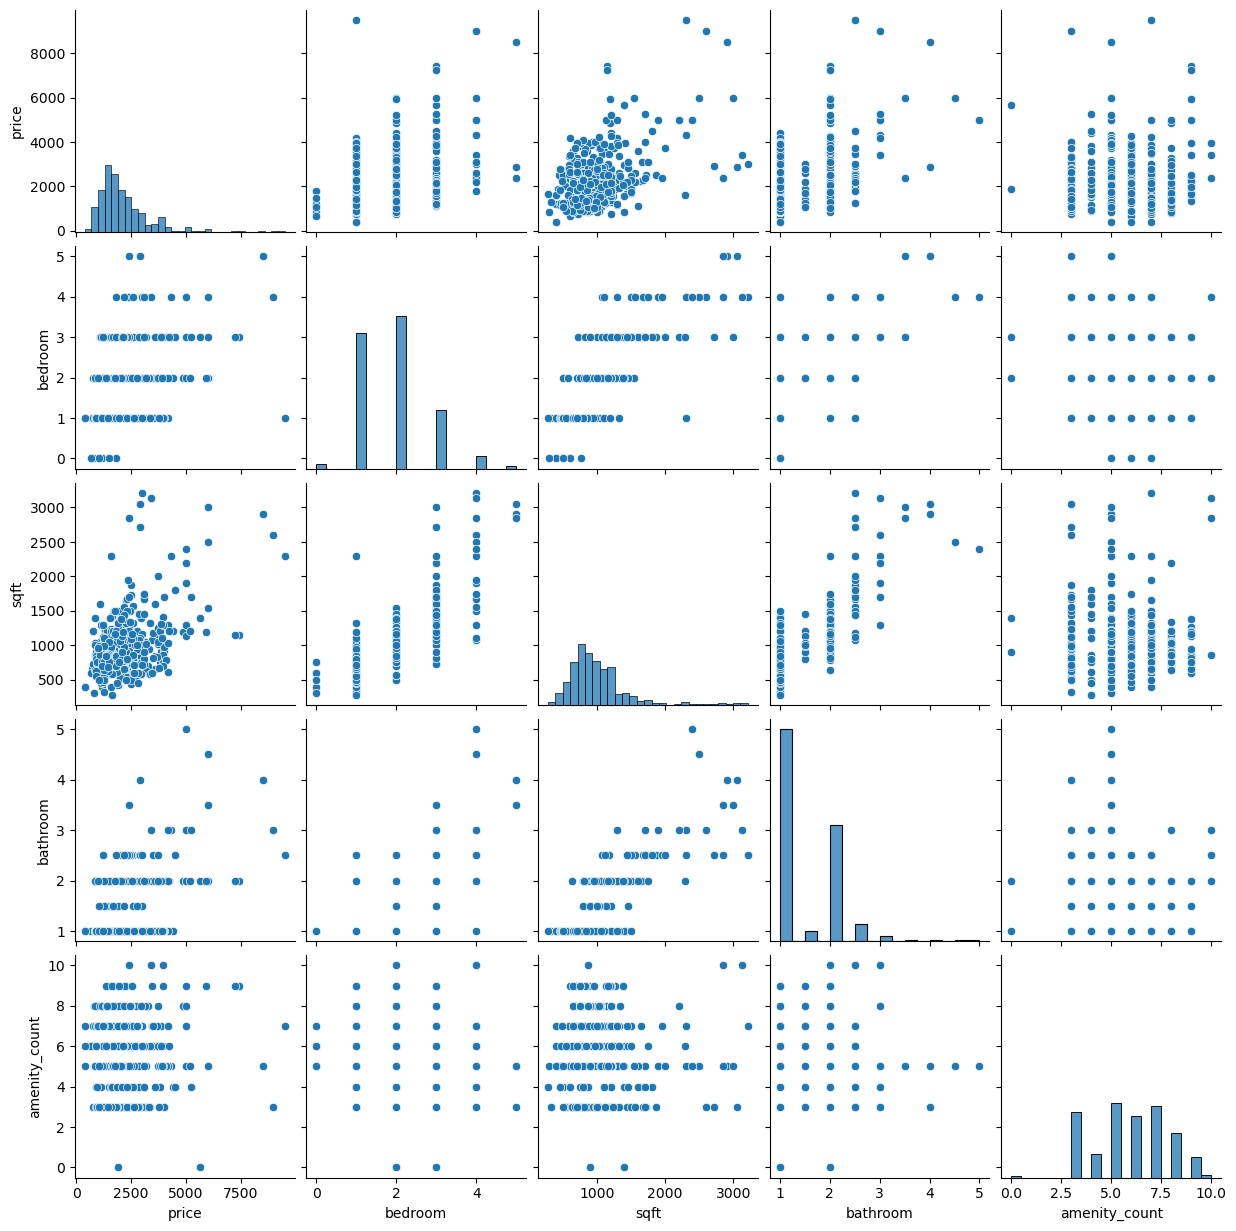

In [12]:
# Examine the dist. of each variable
sns.pairplot(all_train)

### Evaluate Features and Elimate as Appropriate

In [34]:
# Drop features with corr near zero from train and test dfs

all_train.drop(columns=['amenity_count'],axis=1,inplace=True)
all_test.drop(columns=['amenity_count'],axis=1,inplace=True)


### Preprocess Finalized Feature Set

In [35]:
# Remove target

X_train = all_train.drop(columns='price').values
y_train = all_train.price.values

X_test = all_test.drop(columns='price').values
y_test = all_test.price.values

In [36]:
# Scale using RobustScaler due to spread

rs = RobustScaler()

robust = rs.fit(X_train)

X_train_scaled = robust.transform(X_train)

X_test_scaled = robust.transform(X_test)

## Estimator Construction

In [37]:
# Create fn to out scores from cross_val_score to select estimators

def score_info(scores):
    MSE = -scores
    print(f'Mean: {MSE.mean()}')
    print(f'STD: {MSE.std()}')
    return MSE.mean(), MSE.std()

In [38]:
# Gradient Boosting Regressor

gbr_cvs = cross_val_score(GradientBoostingRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

gbr_mean,gbr_std = score_info(gbr_cvs)

Mean: 1198756.1195334957
STD: 554803.0024943643


In [39]:
# Random Forest Regressor

rfr_cvs = cross_val_score(RandomForestRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

rfr_mean,rfr_std=score_info(rfr_cvs)

Mean: 1182511.0691874612
STD: 475984.3633663525


In [40]:
# Lasso

lasso_cvs = cross_val_score(Lasso(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

lasso_mean,lasso_std=score_info(lasso_cvs)

Mean: 1141404.6753926119
STD: 431803.5702883906


In [41]:
# Ridge

ridge_cvs = cross_val_score(Ridge(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ridge_mean,ridge_std=score_info(ridge_cvs)

Mean: 1141614.0142516803
STD: 432568.52978514193


In [42]:
# Adaboost

ada_cvs = cross_val_score(AdaBoostRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ada_mean,ada_std=score_info(ada_cvs)

Mean: 1386215.5184837177
STD: 544626.7721013158


In [43]:
#ARDRegression

ard_cvs = cross_val_score(ARDRegression(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ard_mean,ard_std=score_info(ard_cvs)

Mean: 1141148.6261171526
STD: 432833.82639254513


In [27]:
# To-Do: Plots

## Estimator Tuning

In [45]:
# GBR

model = GradientBoostingRegressor()


mod_params = {
    'learning_rate': [.53,.54,.55,.56,.57],
    'n_estimators': [4,5,6,7],
    'subsample': [1],
    'max_depth': [1,2,3],
    'random_state': [42],
    'max_features': ['sqrt'],
    'alpha': [1e-15,1e-13,1e-11,1e-9,1e-7,1e-5]
}


    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
gbr = model_cv.best_estimator_

Fitting 15 folds for each of 360 candidates, totalling 5400 fits


In [46]:
# RFR

model = RandomForestRegressor()


mod_params = {
    'n_estimators': np.arange(12,25),
    'random_state': [42],
    'max_features': ['sqrt','log2']
}

    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
rfr = model_cv.best_estimator_

Fitting 15 folds for each of 26 candidates, totalling 390 fits


In [48]:
# ADA

model = AdaBoostRegressor()


mod_params = {
    'learning_rate': [.27,.28,.29,.3,.31,.32,.33],
    'n_estimators': np.arange(1,15),
    'random_state': [42]
}

    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
ada = model_cv.best_estimator_

Fitting 15 folds for each of 98 candidates, totalling 1470 fits


In [49]:
# ARD

model = ARDRegression(n_iter=1000)


mod_params = {
    'alpha_1': [1e6,1e7,1e8,1e9,1e10,1e11,1e12],
    'alpha_2': [1e-10,1e-9,1e-8,1e-7],
    'lambda_1': [1e-30,1e-28,1e-26,1e-24,1e-22,1e-20],
    'lambda_2': [1e6,1e7,1e8,1e9,1e10,1e11,1e12]
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
ard = model_cv.best_estimator_
    

Fitting 15 folds for each of 1176 candidates, totalling 17640 fits


In [50]:
lasso = LassoCV(max_iter=5000, cv=15,n_jobs=-1,
               random_state=42)

In [51]:
ridge = RidgeCV()

In [53]:
# Fit Estimators
gbr.fit(X_train_scaled,y_train)
rfr.fit(X_train_scaled,y_train)
ada.fit(X_train_scaled,y_train)
ard.fit(X_train_scaled,y_train)
lasso.fit(X_train_scaled,y_train)
ridge.fit(X_train_scaled,y_train)

RidgeCV()

## Weighted VotingRegressor

### Minimize MSE of models

In [54]:
# Specify number of estimators
n_est = 6

# Create a 'weights' array with default values of 1/n_est
w = (1/n_est)*np.ones(n_est)

In [55]:
# Create vector of predicted values from each estimator
gbr_pred = gbr.predict(X_test_scaled)
rfr_pred = rfr.predict(X_test_scaled)
ada_pred = ada.predict(X_test_scaled)
ard_pred = ard.predict(X_test_scaled)
lasso_pred = lasso.predict(X_test_scaled)
ridge_pred = ridge.predict(X_test_scaled)

In [57]:
# Combine prediction vectors into prediction matrix
mod_pred = np.column_stack((gbr_pred,rfr_pred,ada_pred,ard_pred,lasso_pred,ridge_pred))

In [58]:
# Define Objective Function
def obj_fun(weights=w,y_true=y_test,y_hat=mod_pred, n_estimators=n_est):
    return (1/n_est)*np.sum((y_true - (weights@(y_hat.T)))**2)

In [59]:
# Define constraint(s)
def constraints(weights=w):
    return (1- np.sum(np.abs(weights)))

In [60]:
res = optimize.minimize(obj_fun, (1/n_est)*np.ones(n_est), method='SLSQP',
                  constraints={'fun': constraints,
                              'type': 'eq'}, options={'maxiter': 1000})
res

     fun: 15893355.713461893
     jac: array([7130828.   , 7972247.875, 7949988.75 , 7495922.5  , 7118060.875,
       7381565.375])
 message: 'Optimization terminated successfully'
    nfev: 207
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([2.45379872e-01, 2.75683772e-01, 3.24535165e-03, 8.21619883e-07,
       2.06997389e-01, 2.68692794e-01])

In [61]:
optimal_mod_weights = res.x

In [62]:
# Scale weights

# First argsort returns array with first value is the index of the smallest value
# in the array provided
scaled_weights = np.argsort(optimal_mod_weights)

# Second sort returns array firs value the index of the smallest value of input
# Such that the largest value in optimal_mod_weights will have the largest index
# The resulting array has sorted and scaled from len(array) to 0

scaled_weights = np.argsort(scaled_weights)

# Add 1 to prevent zero weights
scaled_weights = scaled_weights + 1
scaled_weights

array([4, 6, 2, 1, 3, 5], dtype=int64)

### Create VotingRegressor with new weights

In [63]:
estimators = [('gbr',gbr),('rfr',rfr),('ada',ada),('ard',ard),('lasso',lasso),('ridge',ridge)]

vrg = VotingRegressor(estimators,
                     weights=scaled_weights,
                     n_jobs=-1)

vrg.fit(X_train_scaled, y_train)

VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(alpha=1e-15,
                                                       learning_rate=0.55,
                                                       max_depth=1,
                                                       max_features='sqrt',
                                                       n_estimators=5,
                                                       random_state=42,
                                                       subsample=1)),
                            ('rfr',
                             RandomForestRegressor(max_features='sqrt',
                                                   n_estimators=23,
                                                   random_state=42)),
                            ('ada',
                             AdaBoostRegressor(learning_rate=0.28,
                                               n_estimators=5,
                                               random_state=42)),
                            ('ard',
                             ARDRegression(alpha_1=1000000.0, alpha_2=1e-07,
                                           lambda_1=1e-30, lambda_2=1000000.0,
                                           n_iter=1000)),
                            ('lasso',
                             LassoCV(cv=15, max_iter=5000, n_jobs=-1,
                                     random_state=42)),
                            ('ridge', RidgeCV())],
                n_jobs=-1, weights=array([4, 6, 2, 1, 3, 5], dtype=int64))

In [64]:
# Compute cv score for comparison
vrg_cvs = cross_val_score(vrg,X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

vrg_mean,vrg_std = score_info(vrg_cvs)

Mean: 1067709.9638467901
STD: 436734.20511730685


In [65]:
# Display Score on train vs. test
print(f'Training Score: {vrg.score(X_train_scaled, y_train)}')
print(f'Testing Score: {vrg.score(X_test_scaled, y_test)}')

Training Score: 0.4981614829499126
Testing Score: 0.23096110843474316
